# Нейросети для RL

Здесь мы разберем как аппроксимировать функцию стоимости и стратегию с помощью НС на упрощенном учебном примере

Среда - клеточный мир размером 1хN (на картинке ниже, среда размером 1x5)

![title](environment.png)

Цель: достижение терминального состояния из любой клетки за минимальное количество действий.

Для решения задачи очень удобно реализовать среду в виде класса (это стандарт в RL) с методом step, который принимает на вход действие агента, на выходе возвращает новое состояние среды и награду за текущее действие. 

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Определение среды 1xN клеточного мира
class GridWorld1xN:
    def __init__(self, N):
        self.N = N
        self.start_state = 0  # индексация от 0
        self.reset()
    
    def reset(self):
        self.agent_pos = self.start_state
        return self.agent_pos
    
    def step(self, action):
        # Действие: 0 - влево, 1 - вправо
        if action == 0:
            self.agent_pos = max(0, self.agent_pos - 1)
        elif action == 1:
            self.agent_pos = min(self.N - 1, self.agent_pos + 1)
        else:
            raise ValueError("Некорректное действие")
        
        done = self.agent_pos == self.N - 1
        reward = 1.0 if done else -0.1  # небольшой штраф за каждый шаг
        return self.agent_pos, reward, done


# DQN

Основное уравнение для Q learning
$$ Q(s,a) = r + \gamma\max_{a'}(Q(s',a')$$
Обновление состояний
$$ Q(s,a) =Q(s,a) + \alpha( r + \gamma\max_{a'}(Q(s',a') - Q(s,a))$$
В методе Q learning (в методах основанных на оценке стоимости), каждому значению s и a мы должны поставить в соответствие значение Q, т.е. получить таблицу соответсвий. Далее, основываясь на таблице соответствий мы сразу имеем оптимальную стратению. Если таких значений (размер таблицы) больше разумного, вычислительно очень трудно (или невозможно) сделать расчет всех значений Q. Наиболее эффективный способ это обойти - исользовать НС.  
Аппроксимация Q нейронной сетью: теперь Q зависит не только от пары (s,a) но также и от параметров НС w:
$$ Q(s,a,w) = r + \gamma\max_{a'}Q(s',a',w)$$
Ошибка (loss функция) для Q learning:
$$L = ( r + \gamma\max_{a'}Q(s',a',w) - Q(s,a,w))^2$$
Если мы будем вносить поправки в веса на основе текущей ошибки, то мы будем обновлять как занчение $Q(s',a',w)$ так и значение $Q(s,a,w)$. Но для наших методов, такой подход будет очень плохо работать (или совсем не работать), т.к. обновление $Q(s',a',w)$ происходит из прошлого, а наша задача обновиться из будущего (вся информация, которая нам нужна находится в будущем). По этому, делают следующую процедуру: создают нейросеть и дублируют ее. Одна нейросеть называется police, она обучется, вторая target - эта сеть с фиксированными весами. Через определенное количество эпох веса policy передаются в target.  
Перепишем ошибку с учетом того, что у нас 2 нейросети
$$L = ( r + \gamma\max_{a'}Q_{target}(s',a',w) - Q_{policy}(s,a,w))^2$$
Обновление весов $w_i$
$$ \Delta w_i = \frac{\partial L}{\partial w_i} = -2( r + \gamma\max_{a'}Q_{target}(s',a',w) - Q_{policy}(s,a,w))\frac{\partial Q_{policy}(s,a,w)}{\partial w_i} $$


Эпизод 0, Награда: -3.0000000000000018
Эпизод 10, Награда: -3.0000000000000018
Эпизод 20, Награда: -2.0000000000000013
Эпизод 30, Награда: 0.10000000000000009
Эпизод 40, Награда: -0.09999999999999987


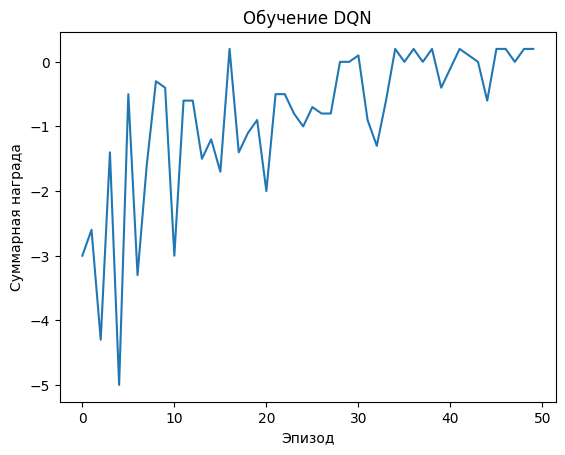

In [60]:
# Гиперпараметры
N = 10  # размер клетки
EPISODES = 50
GAMMA = 0.99
LR = 0.1
BATCH_SIZE = 16
MEMORY_SIZE = 64
EPS_START = 1.0
EPS_END = 0.05
EPS_DECAY = 500

# Определение сети DQN
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size)
        )
    
    def forward(self, x):
        return self.fc(x)

# Агент DQN
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.action_size = action_size
        self.policy_net = DQN(state_size, action_size)
        self.target_net = DQN(state_size, action_size)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.steps_done = 0
    
    def select_action(self, state):
        eps_threshold = EPS_END + (EPS_START - EPS_END)* np.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1
        if random.random() < eps_threshold:
            return random.randrange(self.action_size)
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).unsqueeze(0)
                q_values = self.policy_net(state)
                return q_values.argmax().item()
    
    def store_transition(self, transition):
        self.memory.append(transition)
    
    def optimize(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)
        
        current_q = self.policy_net(states).gather(1, actions)
        max_next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
        target_q = rewards + (GAMMA * max_next_q * (1 - dones))
        loss = nn.MSELoss()(current_q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

# Обучение DQN
#def train_dqn():
env = GridWorld1xN(N)
state_size = 1
action_size = 2
agent = DQNAgent(state_size, action_size)
rewards_per_episode = []

for episode in range(EPISODES):
    state = env.reset()
    state = np.array([state], dtype=np.float32) / (N -1)  # нормализация
    total_reward = 0
    done = False
    
    while not done:
        action = agent.select_action(state)
        next_state, reward, done = env.step(action)
        next_state_normalized = np.array([next_state], dtype=np.float32) / (N -1)
        agent.store_transition((state, action, reward, next_state_normalized, done))
        state = next_state_normalized
        total_reward += reward
        agent.optimize()
    
    rewards_per_episode.append(total_reward)
    
    if episode % 10 == 0:
        agent.update_target()
        print(f"Эпизод {episode}, Награда: {total_reward}")

# Визуализация результатов
plt.plot(rewards_per_episode)
plt.xlabel('Эпизод')
plt.ylabel('Суммарная награда')
plt.title('Обучение DQN')
plt.show()

# Запуск обучения DQN
#train_dqn()



## Policy Gradient
В этом методе мы аппроксимируем стратегию агента нейронной сетью. 
### Алоритм
1. Выбор действия:
Сначала агент выбирает действие $a_t$ на основе текущего состояния $s_t$. Таким образом на вход НС подается состояние, выход НС - распределение вероятностей по возможным действиям - $ \pi(a_t | s_t)$
2. От распределения вероятностей переходим к логарифмам  $ \log(\pi(a_t | s_t))$
3. Ожидаемая награда:
$$ R_t = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} +... $$
4. Ошибка:
$$ L = -\log(\pi(a_t | s_t))R_t $$

### Обучение
$$ \nabla L = -\nabla\log(\pi(a_t | s_t))R_t $$


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

# Параметры
N = 10  # Размер клеточного мира
num_episodes = 1000
max_steps = 10
gamma = 0.99  # Дисконтированный коэффициент

# Нейронная сеть для стратегии
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Linear(N, 2)  # 2 действия: влево и вправо

    def forward(self, x):
        return torch.softmax(self.fc(x), dim=-1)

# Инициализация агентов и оптимизаторов
policy_network = PolicyNetwork()
optimizer = optim.Adam(policy_network.parameters(), lr=0.01)

def select_action(state):
    state_tensor = torch.FloatTensor(state)
    probabilities = policy_network(state_tensor)
    action = np.random.choice([0, 1], p=probabilities.detach().numpy())
    return action

#def train():
for episode in range(num_episodes):
    state = np.zeros(N)  # Начальное состояние
    state[0] = 1  # Агент начинает с первой клетки
    rewards = []
    actions = []
    states = []

    for step in range(max_steps):
        action = select_action(state)
        states.append(state.copy())
        actions.append(action)

        # Применение действия
        if action == 0 and np.argmax(state) > 0:  # Движение влево
            state[np.argmax(state)] = 0
            state[np.argmax(state) - 1] = 1
        elif action == 1 and np.argmax(state) < N - 1:  # Движение вправо
            state[np.argmax(state)] = 0
            state[np.argmax(state) + 1] = 1

        # Проверка на достижение терминального состояния
        if np.argmax(state) == N - 1:
            rewards.append(1)  # Награда за достижение цели
            break
        else:
            rewards.append(-0.1)  # Штраф за шаг

    # Обучение сети на основе собранных данных
    rewards = np.array(rewards)
    discounted_rewards = np.zeros_like(rewards)
    
    for t in range(len(rewards)):
        R = sum(gamma ** (i - t) * rewards[i] for i in range(t, len(rewards)))
        discounted_rewards[t] = R
    
    discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + 1e-8)

    for t in range(len(rewards)):
        state_tensor = torch.FloatTensor(states[t])
        action_probabilities = policy_network(state_tensor)
        action_log_prob = torch.log(action_probabilities[action])
        loss = -action_log_prob * discounted_rewards[t]  # Убыток согласно REINFORCE
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()




Стратегия в произвольном месте клеточного мира

In [17]:
s = torch.zeros(10)
s[6] = 1
policy_network(s)

tensor([1.5347e-10, 1.0000e+00], grad_fn=<SoftmaxBackward0>)

В итоге, агент с вероятностью почти 1 делает оптимальное действие